In [1]:
#Load a specific lightcurve file for testing purposes
import json
import sys
import numpy as np
import emcee
import george
import matplotlib.pyplot as plt
sys.path.append('../classification')
import os
filename = '../gen_lightcurves/gp_smoothed/SN2005el_gpsmoothed.json'
with open(filename, 'r') as f:
     file_data = json.load(f)
print(file_data.keys())

dict_keys(['B_', 'B__CSP', 'B_kait3', 'H_PAIRITEL', 'H__CSP', 'I_kait3', 'J_PAIRITEL', 'J__CSP', 'Ks_PAIRITEL', 'R_kait3', 'U_', 'V_', 'V__CSP', 'V_kait3', 'Y__CSP', 'g__CSP', 'i__CSP', 'r__CSP', 'u__CSP'])


In [2]:
import bandMap
lcurve_mapped = bandMap.remapBands(file_data)
print(lcurve_mapped.keys())

dict_keys(['u', 'g', 'r', 'i', 'Y'])


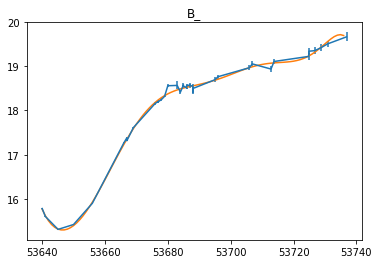

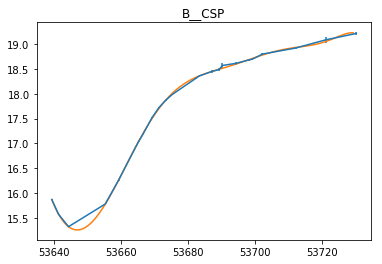

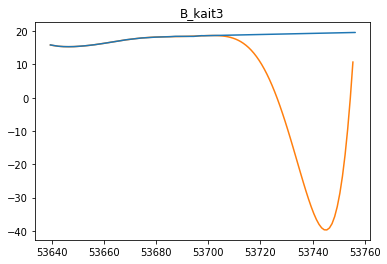

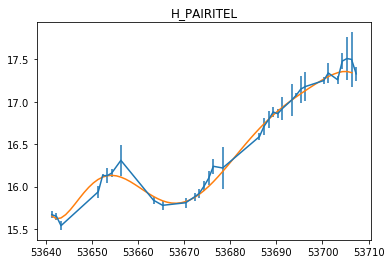

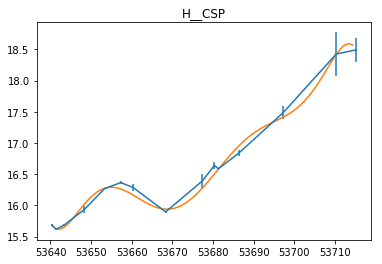

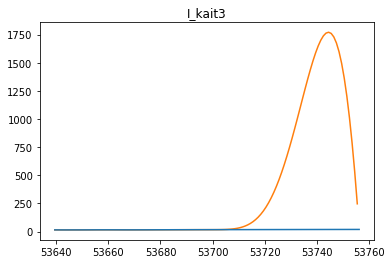

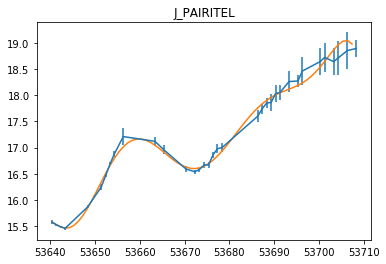

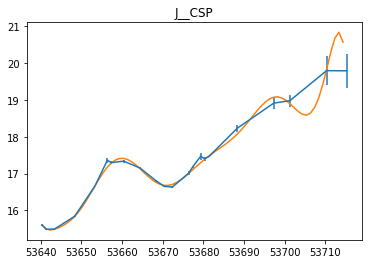

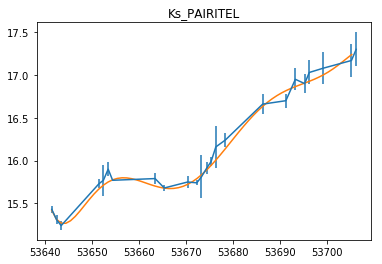

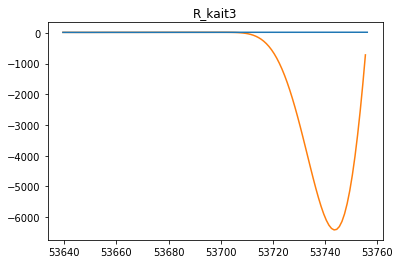

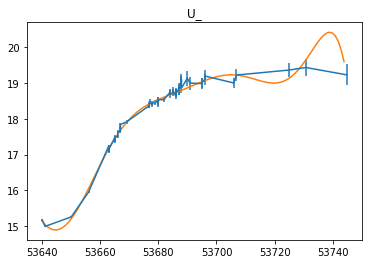

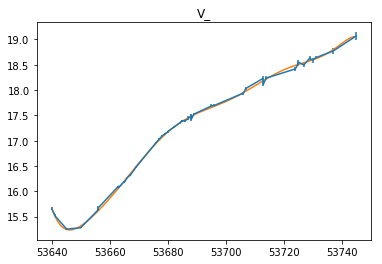

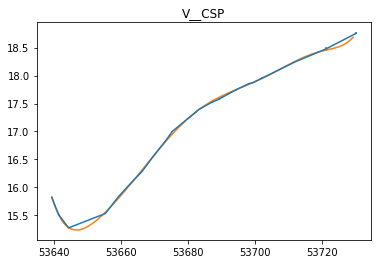

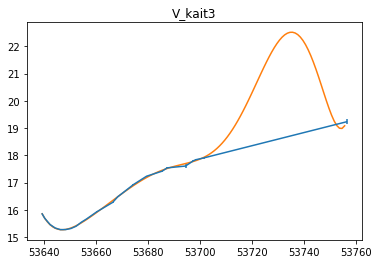

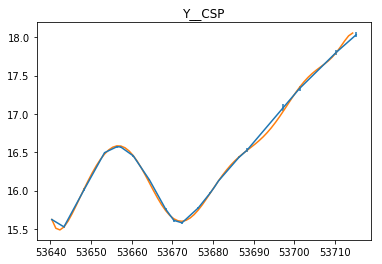

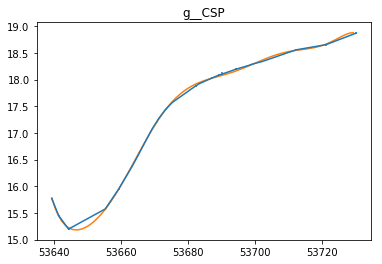

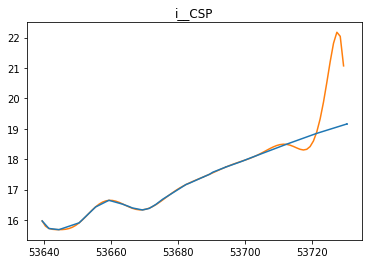

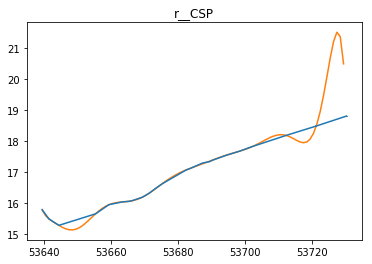

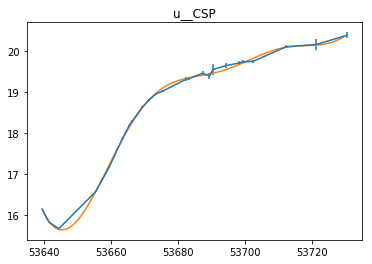

In [3]:
for filt in file_data:
    mjd = np.array(file_data[filt]['mjd'])
    mag = np.array(file_data[filt]['mag'])
    magerr = np.array(file_data[filt]['dmag'])
    modelmjd = file_data[filt]['modeldate']
    modelmag = file_data[filt]['modelmag']
    
    plt.errorbar(mjd,mag,yerr=magerr)
    plt.plot(modelmjd, modelmag)
    plt.title(filt)
    plt.show()

dict_keys(['bsplinemag', 'dmag', 'goodstatus', 'kernel', 'mag', 'mjd', 'modeldate', 'modelerr', 'modelmag', 'modelmag_sub', 'type'])


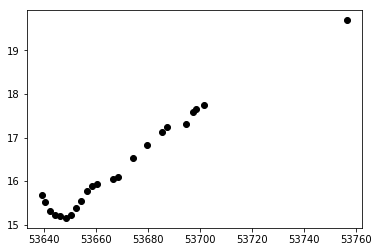

In [4]:
print(file_data['B_'].keys())
filter_name = 'R_kait3'
t = np.array(file_data[filter_name]['mjd'])
y = np.array(file_data[filter_name]['mag'])
err = np.array(file_data[filter_name]['dmag'])
plt.plot(t,y, 'ko')
plt.show()

In [5]:
from george import kernels
#kernel = kernels.ConstantKernel(1*10**-3) * kernels.ExpSquaredKernel(100.) * kernels.DotProductKernel()
#kernel = kernels.ExpSquaredKernel(100.) * kernels.DotProductKernel()
#kernel =  kernels.Matern32Kernel(50.)*kernels.ConstantKernel(50.) * kernels.ExpSquaredKernel(100)
#kernel =  kernels.Matern32Kernel(50.)*kernels.ConstantKernel(50.) * kernels.ExpSquaredKernel(100) * kernels.DotProductKernel()
kernel = kernels.ConstantKernel(50.) * kernels.Matern52Kernel(50.)

In [6]:
import scipy.optimize as op

gp = george.GP(kernel, mean=np.mean(y))

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    ll = gp.lnlikelihood(y, quiet=True)

    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    return -gp.grad_lnlikelihood(y, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(t, err)

# Print the initial ln-likelihood.
print(gp.lnlikelihood(y))

# Run the optimization routine.
p0 = gp.kernel.vector
results = op.minimize(nll, p0, jac=grad_nll)

# Update the kernel and print the final log-likelihood.
gp.kernel[:] = results.x
print(gp.lnlikelihood(y))
print(gp.kernel.pars)

-40.1070337887
13.4473183575
[   3.15576582  483.91533756]


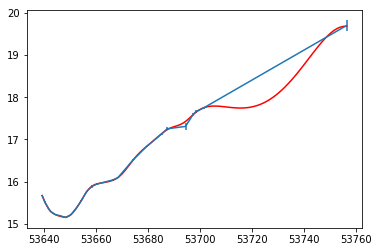

In [8]:
x = np.linspace(min(t), max(t), 100)
mu, cov = gp.predict(y,x)
std = np.sqrt(np.diag(cov))
plt.plot(x,mu, color='r')
plt.errorbar(t,y,yerr=err)
plt.show()

In [9]:
kernel.pars

array([   3.15576582,  483.91533756])

In [ ]:
gp = george.GP(kernel, mean=np.mean(y))
gp.compute(t, err)
print(gp.lnlikelihood(y))
print(gp.grad_lnlikelihood(y))

def lnprob(p):
    # Trivial improper prior: uniform in the log.
    if np.any((-10 > p) + (p > 10)):
        return -np.inf
    lnprior = 0.0

    # Update the kernel and compute the lnlikelihood.
    kernel.pars = np.exp(p)
    return lnprior + gp.lnlikelihood(y, quiet=True)
# You need to compute the GP once before starting. Then the sample list
# will be saved.

# Set up the sampler.
nwalkers, ndim = 36, len(kernel)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Initialize the walkers.
p0 = [np.log(kernel.pars) + 1e-4 * np.random.randn(ndim)
      for i in range(nwalkers)]

print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, 2000)

print("Running production chain")
sampler.run_mcmc(p0, 2000)

In [ ]:
x = np.linspace(min(t),max(t), 100)
chain = sampler.chain
for i in range(50):
    # Choose a random walker and step.
    w = np.random.randint(chain.shape[0])
    n = np.random.randint(2000, chain.shape[1])
    gp.kernel.pars = np.exp(chain[w, n])

    # Plot a single sample.
    plt.plot(x, gp.sample_conditional(y, x), "k", alpha=0.3)
plt.show()